#Начальные установки и загрузка

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import sys
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import random

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,TimeDistributed,Reshape
from keras.utils import Sequence
from keras.models import load_model
from keras.metrics import Accuracy, Precision, Recall, F1Score

In [2]:
ModelSavePath='/content/drive/MyDrive/internship/karate/models' #Путь к папке  с сохраненными моделями
NetName='2Conv' #Имя модели
win_len=100 #Ширина окна (количество кадро, которое будем одновременно подавать в сеть)
step=3 #шаг сдвига окна при обучении
batch_size=32
# Установить параметры шрифта
font = {'family': 'Arial', 'size': 14}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Грузим основной датасет
data_path = '/content/drive/MyDrive/internship/karate/dataset'
filename = 'dataset__all_features_phase.csv'
df = pd.read_csv(os.path.join(data_path,filename)) #Основной датасет
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,1,...,0.925819,0.330658,-0.183095,0.842526,-0.251213,0.476489,0.787591,0.045598,0.614508,0
1,0,0,0,0,0,0,0,0,0,1,...,0.908620,0.318595,-0.270015,0.847875,-0.252573,0.466171,0.856474,0.052875,0.513474,0
2,0,0,0,0,0,0,0,0,0,1,...,0.820056,0.288839,-0.494045,0.831219,-0.246556,0.498283,0.849801,0.051036,0.524627,0
3,0,0,0,0,0,0,0,0,0,1,...,0.842421,0.290291,-0.453936,0.830638,-0.245556,0.499743,0.846481,0.050976,0.529973,0
4,0,0,0,0,0,0,0,0,0,1,...,0.822300,0.278694,-0.496137,0.847154,-0.250359,0.468669,0.868949,0.052760,0.492081,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,1,0,0,0,0,0,0,0,...,0.698299,0.489481,-0.522291,0.552038,-0.363697,0.750319,0.636238,-0.042069,0.770345,1
142364,0,0,1,0,0,0,0,0,0,0,...,0.704808,0.496040,-0.507139,0.534342,-0.367378,0.761257,0.638538,-0.042032,0.768442,1
142365,0,0,1,0,0,0,0,0,0,0,...,0.770869,0.539021,-0.339435,0.557973,-0.401605,0.726209,0.648042,-0.042260,0.760431,1
142366,0,0,1,0,0,0,0,0,0,0,...,0.771385,0.555455,-0.310540,0.563317,-0.430092,0.705475,0.653394,-0.044460,0.755711,1


#Подготовка датасета

In [5]:
#Оставим только размеченные данные
df=df[df['phase']>0]
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
21405,0,0,1,0,0,0,0,0,0,0,...,0.724715,0.418956,-0.547050,0.673368,-0.227036,0.703584,0.673665,0.008626,0.738987,1
21406,0,0,1,0,0,0,0,0,0,0,...,0.765150,0.433057,-0.476452,0.701309,-0.231413,0.674250,0.693709,0.010833,0.720174,1
21407,0,0,1,0,0,0,0,0,0,0,...,0.839960,0.462930,-0.283130,0.716944,-0.233922,0.656713,0.703570,0.012967,0.710508,1
21408,0,0,1,0,0,0,0,0,0,0,...,0.858573,0.469615,-0.205704,0.729678,-0.236502,0.641589,0.708990,0.014080,0.705078,1
21409,0,0,1,0,0,0,0,0,0,0,...,0.858829,0.465662,-0.213477,0.729441,-0.235111,0.642370,0.707357,0.015864,0.706679,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,1,0,0,0,0,0,0,0,...,0.698299,0.489481,-0.522291,0.552038,-0.363697,0.750319,0.636238,-0.042069,0.770345,1
142364,0,0,1,0,0,0,0,0,0,0,...,0.704808,0.496040,-0.507139,0.534342,-0.367378,0.761257,0.638538,-0.042032,0.768442,1
142365,0,0,1,0,0,0,0,0,0,0,...,0.770869,0.539021,-0.339435,0.557973,-0.401605,0.726209,0.648042,-0.042260,0.760431,1
142366,0,0,1,0,0,0,0,0,0,0,...,0.771385,0.555455,-0.310540,0.563317,-0.430092,0.705475,0.653394,-0.044460,0.755711,1


In [6]:
#Добавим к датасету еще 2 класса (10 - стойка, 11 - Прочее (возвраты и т.д))
df.insert(10,'10',np.zeros(len(df)))
df.insert(11,'11',np.zeros(len(df)))
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
21405,0,0,1,0,0,0,0,0,0,0,...,0.724715,0.418956,-0.547050,0.673368,-0.227036,0.703584,0.673665,0.008626,0.738987,1
21406,0,0,1,0,0,0,0,0,0,0,...,0.765150,0.433057,-0.476452,0.701309,-0.231413,0.674250,0.693709,0.010833,0.720174,1
21407,0,0,1,0,0,0,0,0,0,0,...,0.839960,0.462930,-0.283130,0.716944,-0.233922,0.656713,0.703570,0.012967,0.710508,1
21408,0,0,1,0,0,0,0,0,0,0,...,0.858573,0.469615,-0.205704,0.729678,-0.236502,0.641589,0.708990,0.014080,0.705078,1
21409,0,0,1,0,0,0,0,0,0,0,...,0.858829,0.465662,-0.213477,0.729441,-0.235111,0.642370,0.707357,0.015864,0.706679,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,1,0,0,0,0,0,0,0,...,0.698299,0.489481,-0.522291,0.552038,-0.363697,0.750319,0.636238,-0.042069,0.770345,1
142364,0,0,1,0,0,0,0,0,0,0,...,0.704808,0.496040,-0.507139,0.534342,-0.367378,0.761257,0.638538,-0.042032,0.768442,1
142365,0,0,1,0,0,0,0,0,0,0,...,0.770869,0.539021,-0.339435,0.557973,-0.401605,0.726209,0.648042,-0.042260,0.760431,1
142366,0,0,1,0,0,0,0,0,0,0,...,0.771385,0.555455,-0.310540,0.563317,-0.430092,0.705475,0.653394,-0.044460,0.755711,1


In [7]:
#заполним столбец для стойки и возврата
df.loc[df['phase']==1,'10']=1 #стойка
df.loc[df['phase']==3,'11']=1 #прочее
#остальные метки обнулить
df.loc[df['phase']==1,['0','1','2','3','4','5','6','7','8','9']]=0
df.loc[df['phase']==3,['0','1','2','3','4','5','6','7','8','9']]=0


In [8]:
class_dic={
    0: 'GEDAN BARAI',
    1: 'GYAKU DZUKI',
    2: 'KIDZAMI DZUKI',
    3: 'MAWASHI DZUKI',
    4: 'MAWASHI GERI',
    5: 'MAI GERI KEAGE',
    6: 'SOTO UKE',
    7: 'URA MAWASHI GERI',
    8: 'URAKEN UCHI',
    9: 'UCHI UKE',
    10: 'STANCE',
    11: 'OTHER'
    }

##Разделение на тренеровочную и проверочную выборки

In [9]:
#Посмотрим список файлов и ударов, которые есть в размеченном датасете
kick_list=np.unique(df['main_folder'])
kick_list

array(['ГЕДАН БАРАЙ (БЛОК ПЕРЕДНЕЙ РУКОЙ)',
       'КИДЗАМИ ДЗУКИ (ПРЯМОЙ УДАР ПЕРЕДНЕЙ РУКОЙ)'], dtype=object)

In [10]:
total_file_list=[]
for kick in kick_list:
  file_list=np.unique(df.loc[df['main_folder']==kick,'filename'])
  print (f'для удара {kick} размечены файлы {file_list} \r\n Всего: {len(file_list)} файлов',sep=',')
  total_file_list.extend(file_list)


для удара ГЕДАН БАРАЙ (БЛОК ПЕРЕДНЕЙ РУКОЙ) размечены файлы ['Андрей ГЕДАН БАРАЙ' 'Андрей ГЕДАН БАРАЙ (2)'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 2)'
 'Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  1)'
 'Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  2)' 'Дима ГЕДАН БАРАЙ'
 'Дима ГЕДАН БАРАЙ (2)' 'Максим ГЕДАН БАРАЙ' 'Максим ГЕДАН БАРАЙ '
 'Максим ГЕДАН БАРАЙ (замах прямой рукой  1)'
 'Максим ГЕДАН БАРАЙ (замах прямой рукой  2)'
 'Максим ГЕДАН БАРАЙ (кулак развернут не верно 1)'
 'Максим ГЕДАН БАРАЙ (кулак развернут не верно 2)'
 'Максим ГЕДАН БАРАЙ (поворот корпуса за блоком  1)'
 'Максим ГЕДАН БАРАЙ (поворот корпуса за блоком  2)' 'Миша ГЕДАН БАРАЙ'
 'Миша ГЕДАН БАРАЙ (2)' 'Оля ГЕДАН БАРАЙ' 'Оля ГЕДАН БАРАЙ (2)'
 'Эрика ГЕДАН БАРАЙ' 'Эрика ГЕДАН БАРАЙ (2)'] 
 Всего: 24 файлов
для удара КИДЗАМИ ДЗ

Будет не правильным, если тренировать сеть и валидировать результаты мы будем на данных из одних и тех же файлов. Поэтому, проверять качество обучения будем на тех видеофайлах, которые сеть не видела.

Поэтому, в проверочную вборку будем выбирать не фрагменты с видео, а полностью файлы.

In [11]:
random.seed(42)
val_files_count=len(total_file_list)//5 #20%
val_files=random.choices(total_file_list,k=val_files_count)
print(f'Для Валидационной выборки выбрано {val_files_count} файлов из {len(total_file_list)}')
print(val_files)

Для Валидационной выборки выбрано 9 файлов из 48
['Андрей КИДЗАМИ ДЗУКИ (с низу в верх 1)', 'Андрей ГЕДАН БАРАЙ (2)', 'Максим ГЕДАН БАРАЙ (замах прямой рукой  2)', 'Максим ГЕДАН БАРАЙ', 'Максим КИДЗАМИ ДЗУКИ ', 'Дима КИДЗАМИ ДЗУКИ', 'Миша КИДЗАМИ ДЗУКИ', 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)', 'Оля ГЕДАН БАРАЙ']


In [12]:
#Формируем тренеровочную и валидационную выборки
df_train=df.loc[~df['filename'].isin(val_files)]
df_val=df.loc[df['filename'].isin(val_files)]
print (f'В трененровочной выборке {len(df_train)} записей')
print (f'В проверочной выборке {len(df_val)} записей')

В трененровочной выборке 20105 записей
В проверочной выборке 4661 записей


##Выбор признаков, которые будем подавать в сеть

In [13]:
#сформируем список с названиями колонок для X и Y
column_list=list(df)
x_column_list=[x for x in column_list if x.startswith(('a','g','o'))] #в X  только данные о  cos углов (их имена начинаются на 'a','g','o')
y_column_list=[x for x in column_list if x.isdigit()] # толлько метки
print(f'В X войдут следующие колонки: {x_column_list}')
print(f'В Y войдут следующие колонки: {y_column_list}')

В X войдут следующие колонки: ['a12_14_16', 'a11_13_15', 'a14_12_24', 'a13_11_23', 'a14_12_11', 'a13_11_12', 'a24_26_28', 'a23_25_27', 'a12_24_26', 'a11_23_25', 'a25_27_31', 'a26_28_32', 'a23_11_7', 'a24_12_8', 'g12_11_28_27', 'g12_11_24_23', 'g12_11_26_25', 'g12_11_14_13', 'g12_11_16_15', 'g14_16_13_15', 'g12_14_11_13', 'g24_26_23_25', 'g26_28_25_27', 'o12_14_OY', 'o12_14_OX', 'o12_14_OZ', 'o11_13_OY', 'o11_13_OX', 'o11_13_OZ', 'o14_16_OY', 'o14_16_OX', 'o14_16_OZ', 'o13_15_OY', 'o13_15_OX', 'o13_15_OZ', 'o24_26_OY', 'o24_26_OX', 'o24_26_OZ', 'o23_25_OY', 'o23_25_OX', 'o23_25_OZ', 'o26_28_OY', 'o26_28_OX', 'o26_28_OZ', 'o25_27_OY', 'o25_27_OX', 'o25_27_OZ']
В Y войдут следующие колонки: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']


#Основные функции

##ДатаГенератор

In [14]:
def prepare_x(x_data):
  '''
  Выполняет необходимые преобразования из данных в датафрейме к данным для подачи в сеть
  '''
  x_data=np.arccos(x_data)/np.pi #переведем сразу в радианы и разделим на PI (номировка 0-1)
  return x_data

In [15]:
class TimeSeriesGenerator(Sequence):
    def __init__(self, df,x_columns,y_columns, win_len, batch_size, step=1,aug=None):
        """
        Реализует датагенератор

        Параметры:
        - df - датафрейм с данными
        - x_columns  список колонок,котрые будут выступать в качестве X
        - y_columns  список колонок,котрые будут выступать в качестве Y
        - win_len: Длина последовательности, которую мы будем использовать в каждом батче (окно).
        - batch_size: Размер батча.
        - step: Шаг, на который сдвигается окно при генерации последовательностей.
        - aug: функция аугментации
        """
        self.df = df
        self.x_columns=x_columns
        self.y_columns=y_columns
        self.win_len = win_len
        self.batch_size = batch_size
        self.step = step
        self.indices = self._generate_indices()
        self.aug=aug

    def _generate_indices(self):
        """
        Генерация индексов для выбора случайных последовательностей из временных рядов.

        Returns:
        - indices: Список кортежей (имя файла, начальный индекс ).
        """
        file_names=np.unique(df['filename'])
        indices = []
        for file_name in  file_names:
            file_data=df[df['filename']==file_name]
            for start_index in range(0, len(file_data) - self.win_len + 1, self.step):
                indices.append((file_name, start_index))
        #print(indices)
        return indices

    def __len__(self):
        """
        Возвращает количество батчей в генераторе.

        Returns:
        - Количество батчей.
        """
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        """
        Получение батча данных по индексу.

        Parameters:
        - index: Индекс батча.

        Returns:
        - X_batch: Входные данные батча.
        - y_batch: Выходные данные батча.
        """
        #Выбираем индексы из которых будем формировать батч
        batch_indices = np.random.choice(len(self.indices), size=self.batch_size, replace=False)
        batch_indices = [self.indices[i] for i in batch_indices]

        X_batch = []
        Y_batch = []

        for file_name, start_index in batch_indices:
            end_index = start_index + self.win_len
            data=df[df['filename']==file_name].sort_values('frame#')
            x_data=data[self.x_columns].values[start_index:end_index]
            y_data=data[self.y_columns].values[start_index:end_index]


            x_data=prepare_x(x_data)

            #Если используем аугментацию
            if self.aug is not None:
              x_data,y_data = self.aug(x_data,y_data)

            X_batch.append(x_data)
            Y_batch.append(y_data)

        return np.array(X_batch), np.array(Y_batch)


##Отображение графиков обучения

In [16]:
def show_charts(history,figsize=(25,8), title=None):
  '''Показывает графики истории обучения
  history - словарь из объекта history
  '''
  if history is None or len(history)==0:
    print ('Данные об истории обучения отсутствуют')
    return
  plt.figure(figsize=figsize)
  #график ошибки
  ax=plt.subplot(1,2,1)
  plt.plot(history['loss'],
         label='Ошибка на обучающем наборе')
  plt.plot(history['val_loss'],
         label='Ошибка на проверочном наборе')
  plt.legend()# Отрисовка легенды
  plt.title(title)
  ax.grid()
  plt.xlabel('Эпоха обучения')

  #графики метрик
  ax=plt.subplot(1,2,2)
  keys=list(history.keys())
  keys.remove('loss')
  keys.remove('val_loss')

  for item in keys:
    lable='тренеровочном'
    if item.startswith('val_'):
        lable='проверочном'
    plt.plot(history[item],
         label=f'Доля верных ответов на {lable} наборе {item}')
  # Отрисовка подписей осей
  plt.xlabel('Эпоха обучения')
  plt.title(title)
  ax.grid()
  plt.legend()# Отрисовка легенды
  plt.show()

##Генерация видео

In [17]:
DisplaySkipFrame=10
font = {'family': 'DejaVu Sans', 'size': 36}
def mark_move(data,VideoPathIn, VideoPathOut):
  '''
  маркирует каждый кадр из видео VideoPathIn, в соответствии с данными data.  Формирует новое видео  по VideoPathOut
  data - numpy массив с результатами сегметации сети (количество кадров,количество классов)
  VideoPathIn - путь к исходному видеофайлу
  VideoPathIn - путь к итоговому видеофайлу
  '''
  cap = cv2.VideoCapture(VideoPathIn)
  if (cap.isOpened() == False):
    print("Ошибка открытия видеофайла")
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_size=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  #print (frame_size)
  Output = cv2.VideoWriter(VideoPathOut, cv2.VideoWriter_fourcc(*'MP4V'), fps, frame_size)
  FrameIndex=0
  while(True): # Вывод кадров производится  в цикле
    ret, frame = cap.read()
    if total_frame_count<=FrameIndex:
      break;
    if not ret: #кадр не вернулся по какой то причине
      FrameIndex +=1
      continue
    kick_code=np.argmax(data[FrameIndex])
    cv2.putText(frame, class_dic[kick_code], (10,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), 7)
    cv2.putText(frame, f'frame:{FrameIndex}', (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 7)
    cv2.putText(frame, f'val:{max(data[FrameIndex]):.4f}', (10,300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 7)

      #вывод кадров на экран (для отладки, потом убрать)
    if FrameIndex%DisplaySkipFrame==1: #Начиная с первого кадра каждой секунды
      clear_output(wait=True)
      min_frame =cv2.resize(frame, (int(frame.shape[1]/5),int(frame.shape[0]/5)))
      cv2_imshow(min_frame)
      print (f'Обработано {FrameIndex} кадров')

    Output.write(frame)
    FrameIndex+=1
  Output.release()
  cap.release()
  cv2.destroyAllWindows()
  print (f'Всего обработано {FrameIndex} кадров')

##Предикт

In [18]:
def predict(model,df,x_columns):
  '''
  Вычисляет удар  для каждого кадра

  Параметры:
  model - Модель
  df  - датафрейм с данными для одного видео
  x_columns - список колонок,котрые будут выступать в качестве X

  Возвращает numpy массив с классификацией удара в каждом кадре
  '''
  x_data=df[x_columns].values #Получили np массив
  x_data=prepare_x(x_data) #Сделали необходимые преобразование

  frame_count=len(x_data)
  if frame_count<win_len:
    #очень короткий ролик, добъем до необходимой длины последним кадром
    last_frame=x_data[-1:]
    last_frames=np.tile(last_frame,win_len-frame_count)
    x_data=np.concatenate((x_data, last_frames), axis=0)
    res=np.squeeze(model(np.expand_dims(x_data, axis=0)))
    return res

  #В Видео кадров больше или равно чем win_len, будем подавать в сеть порциями
  c=0
  result_array=np.empty((0, len(y_column_list)))
  #Берем по win_len кадров и прогоняем их через сеть. результат записываем в result_array
  while (c+1)*win_len<=frame_count:
    res=np.squeeze(model(np.expand_dims(x_data[c*win_len:(c+1)*win_len], axis=0)))
    result_array = np.concatenate((result_array, res), axis=0)
    c=c+1

  remains = frame_count-len(result_array) #столько последних кадров надо доразметить
  #Подаем на сеть последние win_len кадров
  res=np.squeeze(model(np.expand_dims(x_data[-win_len:], axis=0)))
  #из результата нас интересуют только последние remains кадров
  res=res[-remains:]
  result_array = np.concatenate((result_array, res), axis=0)
  return result_array



##Создание и компиляция модели

In [19]:

def get_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''
  model = Sequential()

  model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(win_len, features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(win_len* num_classes, activation='softmax'))
  model.add(Reshape((win_len, num_classes)))

  # Компиляция модели
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


#Обучение

In [20]:
train_gen=TimeSeriesGenerator(df_train,x_column_list,y_column_list,win_len,batch_size=batch_size,step=step)
val_gen=TimeSeriesGenerator(df_val,x_column_list,y_column_list,win_len,batch_size=batch_size,step=step)

In [21]:
model=get_model(win_len,len(x_column_list),len(y_column_list))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 32)            4544      
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 1200)              1

In [23]:
epochs=20
#history=model.fit(train_gen,validation_data=val_gen,epochs=epochs)

Epoch 1/20
210/210 [==============================] - 86s 351ms/step - loss: 0.6221 - accuracy: 0.7542 - val_loss: 0.3099 - val_accuracy: 0.8802
Epoch 2/20
210/210 [==============================] - 74s 351ms/step - loss: 0.2845 - accuracy: 0.8886 - val_loss: 0.2697 - val_accuracy: 0.8919
Epoch 3/20
210/210 [==============================] - 63s 300ms/step - loss: 0.2535 - accuracy: 0.8988 - val_loss: 0.2432 - val_accuracy: 0.9021
Epoch 4/20
210/210 [==============================] - 61s 289ms/step - loss: 0.2326 - accuracy: 0.9064 - val_loss: 0.2241 - val_accuracy: 0.9104
Epoch 5/20
210/210 [==============================] - 62s 296ms/step - loss: 0.2217 - accuracy: 0.9112 - val_loss: 0.2163 - val_accuracy: 0.9125
Epoch 6/20
210/210 [==============================] - 60s 288ms/step - loss: 0.2056 - accuracy: 0.9175 - val_loss: 0.1979 - val_accuracy: 0.9206
Epoch 7/20
210/210 [==============================] - 63s 302ms/step - loss: 0.1961 - accuracy: 0.9216 - val_loss: 0.1891 - val_ac

In [24]:
#model.save(os.path.join(ModelSavePath, NetName)) # Сохраняем модель

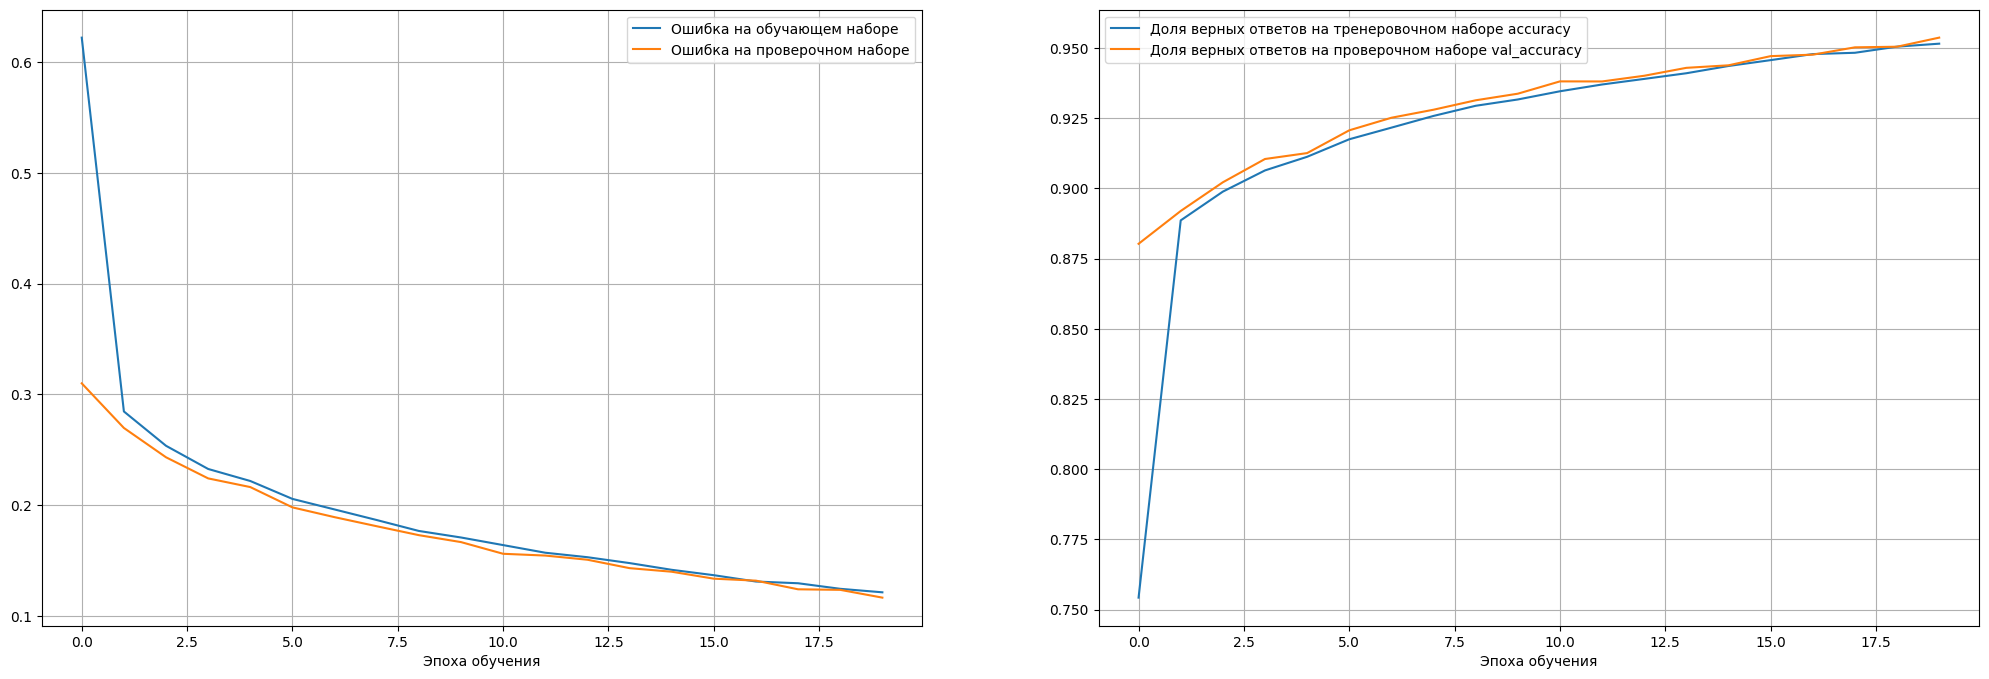

In [24]:
#show_charts(history.history)

#Эксперименты с моделью

In [26]:
model=load_model(os.path.join(ModelSavePath, NetName)) # Загружаем сохраненную модель

##КИДЗАМИ ДЗУКИ из валидационной выборки

In [27]:
#пробуем предиктить на видео, которые сеть не видела (из валидационной выборки)
file_name='Андрей КИДЗАМИ ДЗУКИ (с низу в верх 1)'
df_test=df[df['filename']==file_name].sort_values('frame#')
df_test

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
137331,0,0,0,0,0,0,0,0,0,0,...,0.826833,0.031696,-0.561554,0.526857,0.059569,0.847864,0.986036,0.132896,-0.100357,1
137332,0,0,0,0,0,0,0,0,0,0,...,0.879076,0.030771,-0.475688,0.562310,0.065137,0.824357,0.988090,0.132502,-0.078244,1
137333,0,0,0,0,0,0,0,0,0,0,...,0.889787,0.027640,-0.455539,0.579208,0.067475,0.812382,0.983026,0.132201,-0.127210,1
137334,0,0,0,0,0,0,0,0,0,0,...,0.909230,0.029211,-0.415267,0.580352,0.067609,0.811554,0.984364,0.130917,-0.117850,1
137335,0,0,0,0,0,0,0,0,0,0,...,0.897771,0.031384,-0.439343,0.558549,0.065883,0.826851,0.989761,0.132085,-0.054107,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137793,0,0,0,0,0,0,0,0,0,0,...,0.964043,-0.009050,-0.265592,0.425648,0.085238,0.900865,0.978639,0.064329,0.195262,1
137794,0,0,0,0,0,0,0,0,0,0,...,0.962156,-0.010680,-0.272288,0.440662,0.087360,0.893412,0.981909,0.066985,0.177107,1
137795,0,0,0,0,0,0,0,0,0,0,...,0.956255,-0.010740,-0.292336,0.455559,0.089728,0.885672,0.985281,0.072159,0.154966,1
137796,0,0,0,0,0,0,0,0,0,0,...,0.951990,-0.014649,-0.305779,0.514757,0.097594,0.851763,0.986459,0.076472,0.145089,1


In [28]:
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'

correct=wrong main_folder=КИДЗАМИ ДЗУКИ (ПРЯМОЙ УДАР ПЕРЕДНЕЙ РУКОЙ) folder=front


In [29]:
result=predict(model,df_test,x_column_list)

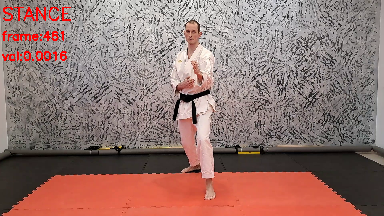

Обработано 461 кадров
Всего обработано 467 кадров


In [30]:
mark_move(result,VideoPathIn,VideoPathOut)

##Максим ГЕДАН БАРАЙ (замах прямой рукой  2) из валидационной выборки

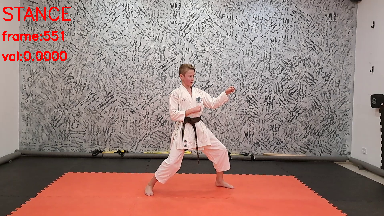

Обработано 551 кадров
Всего обработано 553 кадров


In [31]:
#пробуем предиктить на видео, которые сеть не видела (из валидационной выборки)
file_name='Максим ГЕДАН БАРАЙ (замах прямой рукой  2)'
df_test=df[df['filename']==file_name].sort_values('frame#')
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'
result=predict(model,df_test,x_column_list)
mark_move(result,VideoPathIn,VideoPathOut)

## Примеры из тестового датасета 2308

In [79]:
df_2308=pd.read_csv('/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/dataset_test_all_features_phase.csv')
#Оставим только размеченные данные
df_2308=df_2308[df_2308['phase']>0]
#Посмотрим список размеченных на данный момент ударов файлов
#Посмотрим список файлов и ударов, которые есть в размеченном датасете
kick_list=np.unique(df_2308['main_folder'])
print(f'Размеченные удары: {kick_list}')
total_file_list=[]
for kick in kick_list:
  file_list=np.unique(df_2308.loc[df_2308['main_folder']==kick,'filename'])
  print (f'для удара {kick} размечены файлы {file_list} \r\n Всего: {len(file_list)} файлов',sep=',')
  total_file_list.extend(file_list)

Размеченные удары: ['ГЕДАН БАРАЙ']
для удара ГЕДАН БАРАЙ размечены файлы ['20230814_171314' '20230814_171717' 'не верный замах'
 'не верный замах 2'] 
 Всего: 4 файлов


### Расчет точности на тестовой выборке

In [88]:
#Подготовка датасета
#Добавим к датасету еще 2 класса (10 - стойка, 11 - Прочее (возвраты и т.д))
df_2308.insert(10,'10',np.zeros(len(df_2308)))
df_2308.insert(11,'11',np.zeros(len(df_2308)))
#заполним столбец для стойки и возврата
df_2308.loc[df_2308['phase']==1,'10']=1 #стойка
df_2308.loc[df_2308['phase']==3,'11']=1 #прочее
#остальные метки обнулить
df_2308.loc[df_2308['phase']==1,['0','1','2','3','4','5','6','7','8','9']]=0
df_2308.loc[df_2308['phase']==3,['0','1','2','3','4','5','6','7','8','9']]=0

In [105]:
for file in file_list:
  df_test=df_2308[df_2308['filename']==file]
  Y_test=np.argmax(df_test[y_column_list].values,axis=1)
  result=np.argmax(predict(model,df_test,x_column_list),axis=1)
  m=Accuracy()
  m.update_state(Y_test, result)
  print (f'Файл "{file}" содержит {len(df_test)} кадров. Точность предсказания: {m.result().numpy():.2f}' )




Файл "20230814_171314" содержит 1273 кадров. Точность предсказания: 0.81
Файл "20230814_171717" содержит 1281 кадров. Точность предсказания: 0.72
Файл "не верный замах" содержит 1242 кадров. Точность предсказания: 0.67
Файл "не верный замах 2" содержит 1398 кадров. Точность предсказания: 0.70


###Файл из тестового датасета 20230814_171314

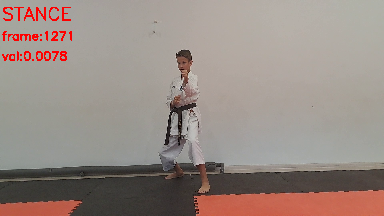

Обработано 1271 кадров
Всего обработано 1273 кадров


In [80]:
file_name='20230814_171314'
df_test=df_2308[df_2308['filename']==file_name].sort_values('frame#')
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'
result=predict(model,df_test,x_column_list)
mark_move(result,VideoPathIn,VideoPathOut)

##Ката

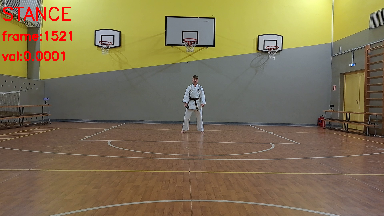

Обработано 1521 кадров
Всего обработано 1529 кадров


In [106]:
#пробуем предиктить на видео ката
df_test=pd.read_csv('/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/dataset_ката_all_features.csv')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/ката/ката центральная камера.mp4'
VideoPathOut=f'/content/ката_Marked_v2.mp4'
result=predict(model,df_test,x_column_list)
#result[np.where(np.max(result,axis=1)<0.01)][:,11]=1 #Если уверенность меньше порога, считаем что это класс неизвестно
mark_move(result,VideoPathIn,VideoPathOut)